In [323]:
import os

import numpy as np
import scipy.signal
from numba import njit
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import scipy

In [331]:
@njit
def sinc_window(win_size, a=3):
    x = np.arange(1, win_size + 1)
    sincs = np.sin(x) / x * np.sin(x / a) / (x / a)
    sincs = np.concatenate((sincs[::-1], np.array([1.0]), sincs))
    return sincs


@njit
def filter_signal(signal, filter_size, a=3) -> np.array:
    signal = signal.copy()
    signal_padded = np.concatenate((np.ones(filter_size) * signal[0], signal, np.ones(filter_size) * signal[-1]))
    out = np.zeros(len(signal))
    for i in range(len(signal)):
        sincs = sinc_window(filter_size, a)
        vals = signal_padded[i:i + 2 * filter_size + 1]
        out[i] = (sincs @ vals) / np.sum(sincs)

    return out


@njit
def create_sin_signal(f):
    xx = np.linspace(0, 2 * np.pi, 10000)
    return np.sin(f * xx)


@njit
def create_square_signal(f):
    n = 10000
    n_repeat_units = n // f // 4
    a = np.array([[1,-1], [1, -1]])
    res = np.repeat(np.repeat(a, f, axis=0), n_repeat_units, axis=1).flatten()
    return res


@njit
def get_throughput(f_range, filter_width, a=3):
    throughputs = [0.0]
    for f in f_range:
        sig = create_sin_signal(f)
        filtered_sig = filter_signal(sig.copy(), filter_width, a)
        throughput = np.sum(np.abs(filtered_sig)) / np.sum(np.abs(sig))
        throughputs += [throughput]

    return np.array(throughputs[1:])

def get_throughput2(f_range, filter_width, a=3):
    throughputs = [0.0]
    for f in f_range:
        sig = create_sin_signal(f)
        kernel = sinc_window(filter_width, a)
        kernel = kernel / np.sum(kernel)
        filtered_sig = scipy.signal.convolve(sig.copy(), kernel, mode='same')
        throughput = np.sum(np.abs(filtered_sig)) / np.sum(np.abs(sig))
        throughputs += [throughput]

    return np.array(throughputs[1:])


print(filter_signal(np.array([0, 0, 0, 1, 0, 0, 0]), 1))

[0.         0.         0.31145943 0.37708115 0.31145943 0.
 0.        ]


0: 0
1: 1
2: 0
3: -1
4: 0
5: 1

In [327]:
kernel = [0.5, 1, 0.5]
sig = [0, 1, 0, 1, 0, 0, 0]
filtered_sig = scipy.signal.convolve(sig, kernel, mode='same')
print(filtered_sig)

[0.5 1.  1.  1.  0.5 0.  0. ]


In [299]:
n = 20
f = 4
n_repeat_units = f
max_len = n - n % f
print(max_len)
a = np.concatenate([np.repeat([1, -1], n_repeat_units), np.repeat([1, -1], n_repeat_units)])[:max_len]
print(a)
b = a.reshape(-1, f//2).T.flatten()
print(b)

20
[ 1  1  1  1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1]
[ 1  1 -1 -1  1  1 -1 -1  1  1 -1 -1  1  1 -1 -1]


In [304]:
def create_square_signal(f):
    n = 10
    xx = np.arange(1, n, 1)
    res = [-1 for i in xx if _ % f < f // 2]
    return b

f = 9
b = create_square_signal(f)
plt.plot(b)

19
[ 1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1]


ValueError: cannot reshape array of size 19 into shape (4)

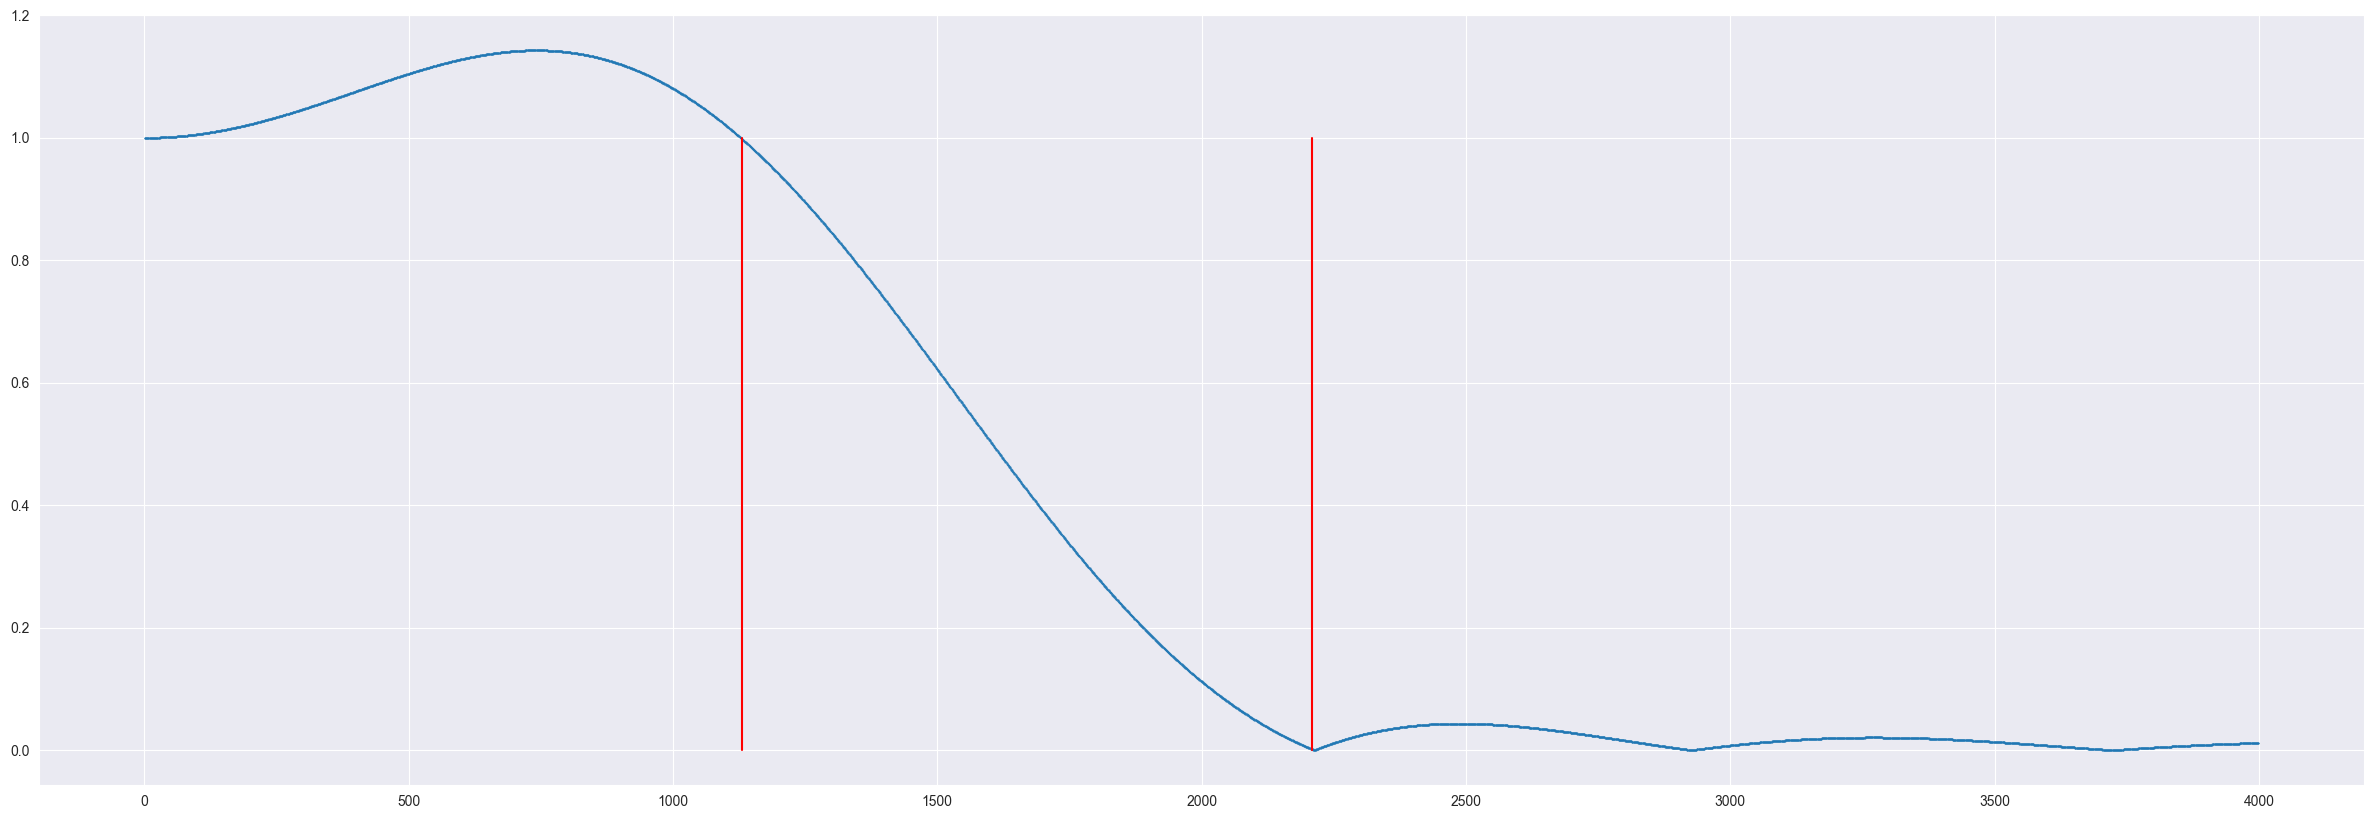

In [332]:
xx = np.arange(1, 4000, 1)
throughputs = get_throughput2(xx, 6, 4)
upper_cutoff = np.argmax(throughputs < 0.998)
lower_cutoff = np.argmax(throughputs < 0.002)

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.plot(xx, throughputs, ".", markersize=1)
plt.plot([xx[upper_cutoff], xx[upper_cutoff]], [0, 1], "r")
plt.plot([xx[lower_cutoff], xx[lower_cutoff]], [0, 1], "r")

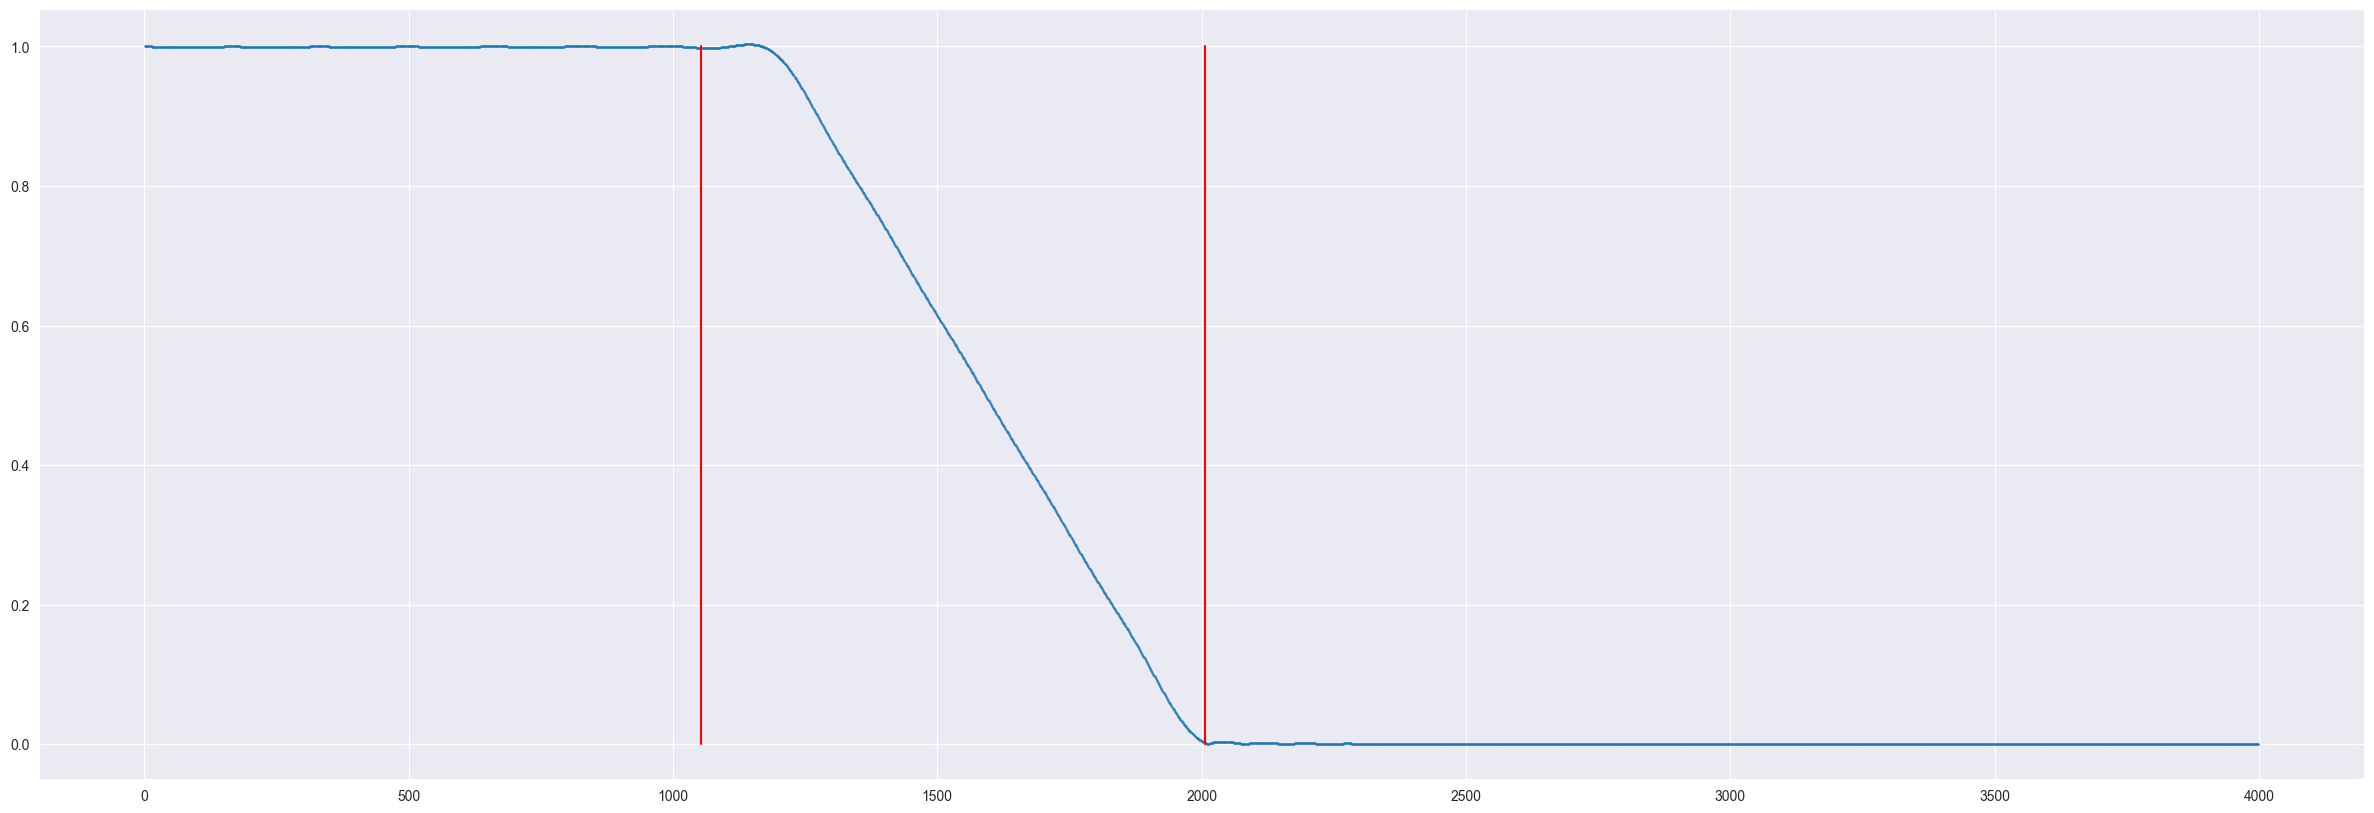

In [333]:
xx = np.arange(1, 4000, 1)
throughputs = get_throughput2(xx, 60, 4)
upper_cutoff = np.argmax(throughputs < 0.998)
lower_cutoff = np.argmax(throughputs < 0.002)

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.plot(xx, throughputs, ".", markersize=1)
plt.plot([xx[upper_cutoff], xx[upper_cutoff]], [0, 1], "r")
plt.plot([xx[lower_cutoff], xx[lower_cutoff]], [0, 1], "r")

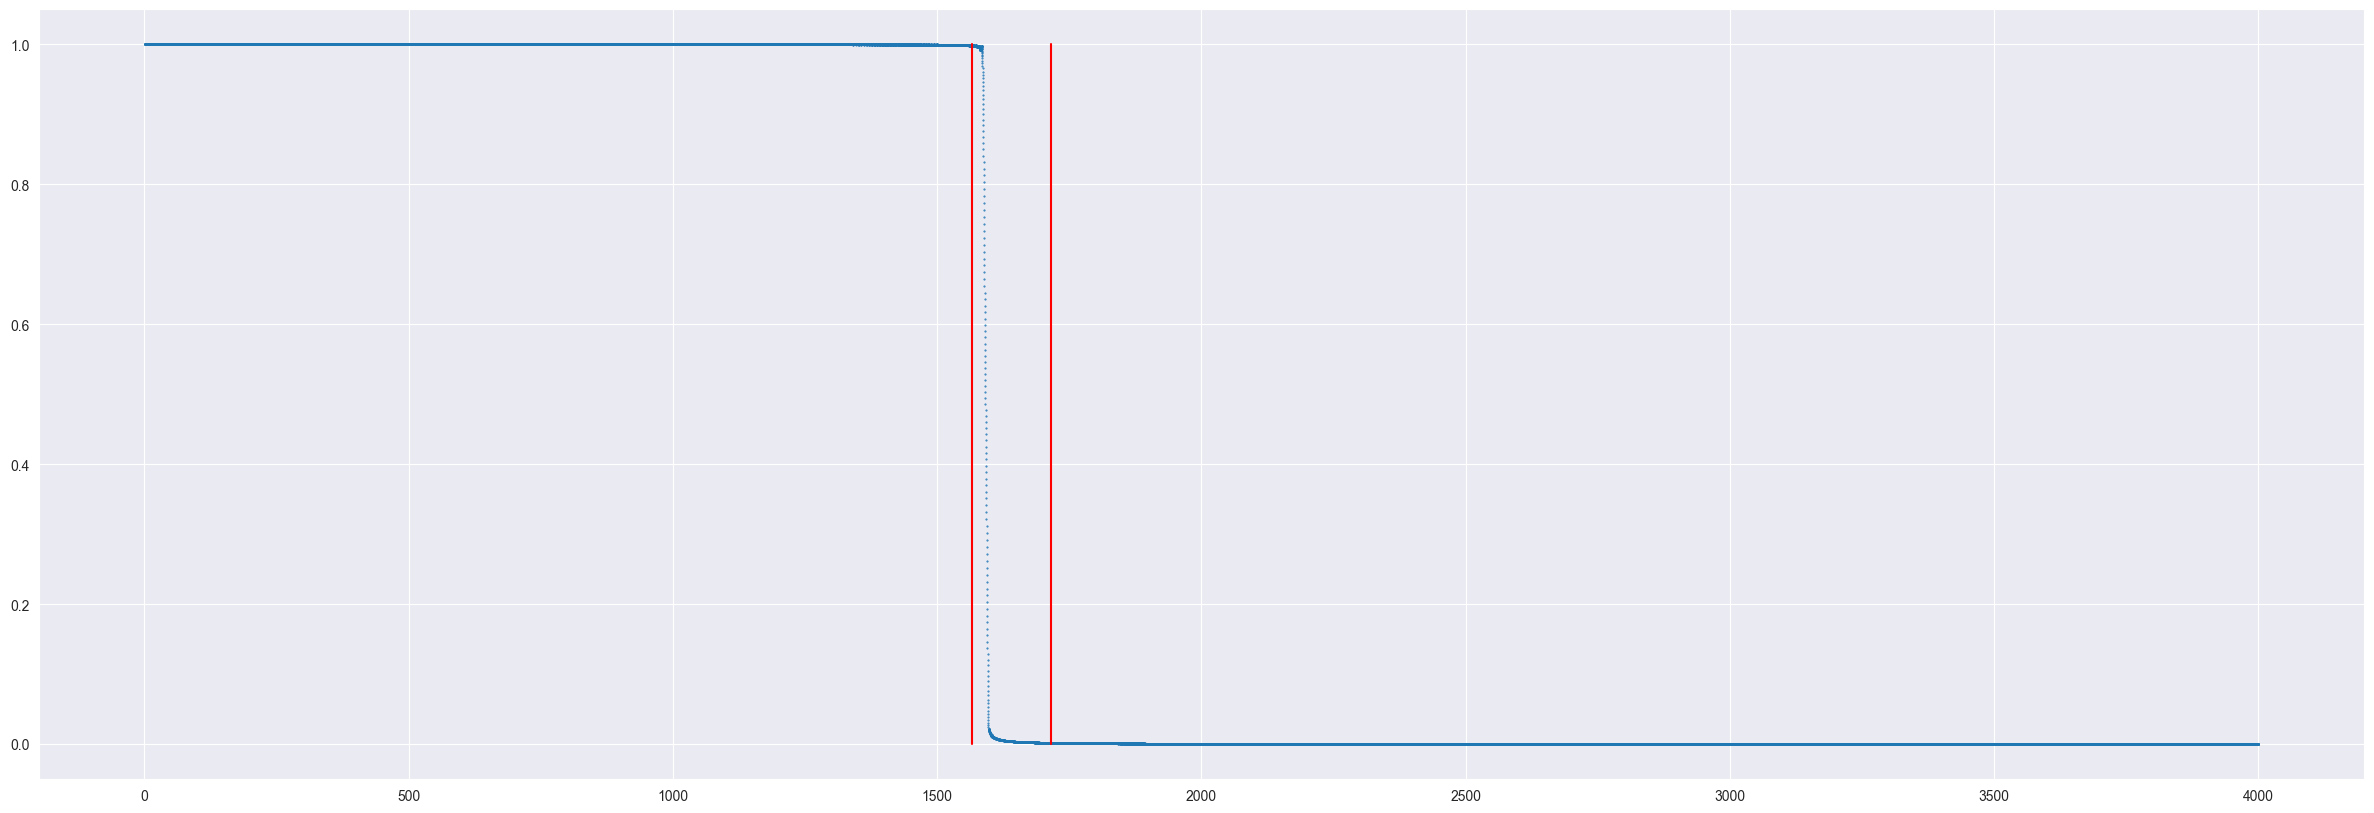

In [338]:
xx = np.arange(1, 4000, 0.1)
throughputs = get_throughput2(xx, 2000, 300)
upper_cutoff = np.argmax(throughputs < 0.998)
lower_cutoff = np.argmax(throughputs < 0.002)

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.plot(xx, throughputs, ".", markersize=1)
plt.plot([xx[upper_cutoff], xx[upper_cutoff]], [0, 1], "r")
plt.plot([xx[lower_cutoff], xx[lower_cutoff]], [0, 1], "r")

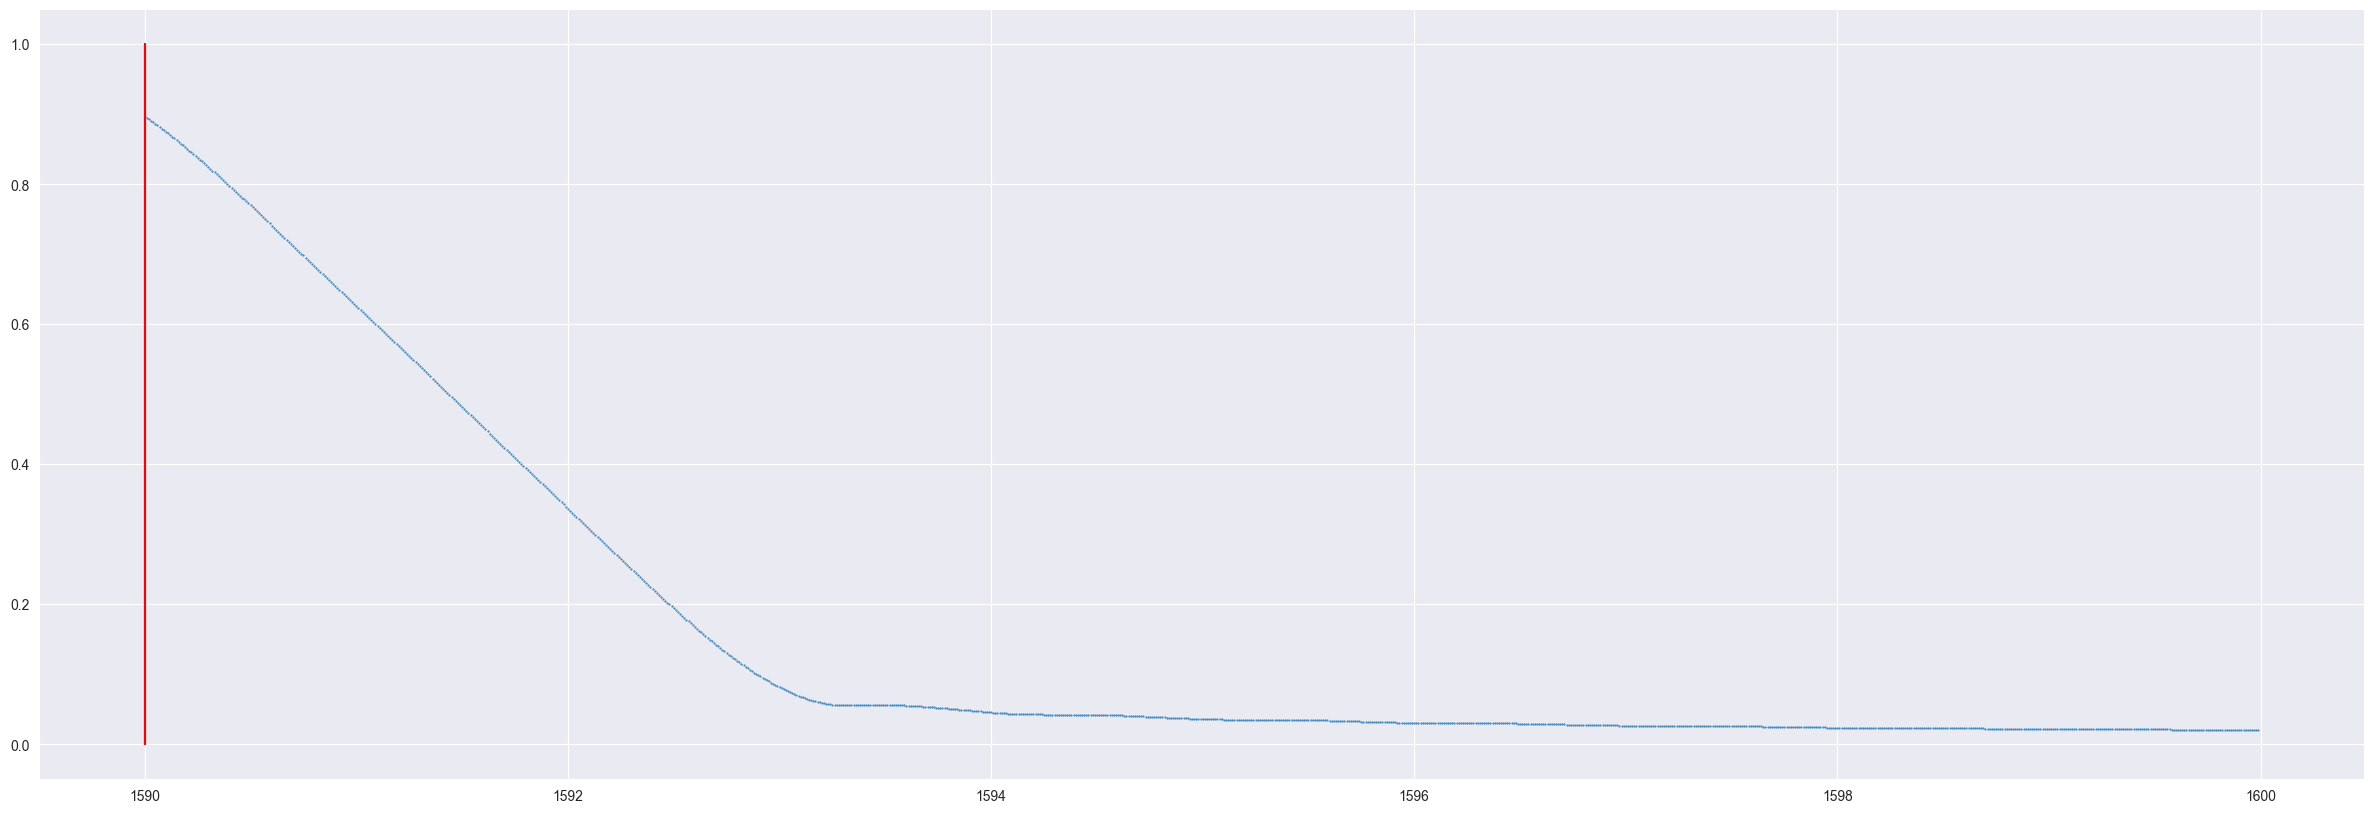

In [351]:
xx = np.arange(1590, 1600, 0.01)
throughputs = get_throughput2(xx, 10000, 1000)
upper_cutoff = np.argmax(throughputs < 0.998)
lower_cutoff = np.argmax(throughputs < 0.002)

fig, ax = plt.subplots(1, 1, figsize=(30, 10))
plt.plot(xx, throughputs, ".", markersize=1)
plt.plot([xx[upper_cutoff], xx[upper_cutoff]], [0, 1], "r")
plt.plot([xx[lower_cutoff], xx[lower_cutoff]], [0, 1], "r")

Text(0.5, 1.0, 'Filtered Signal')

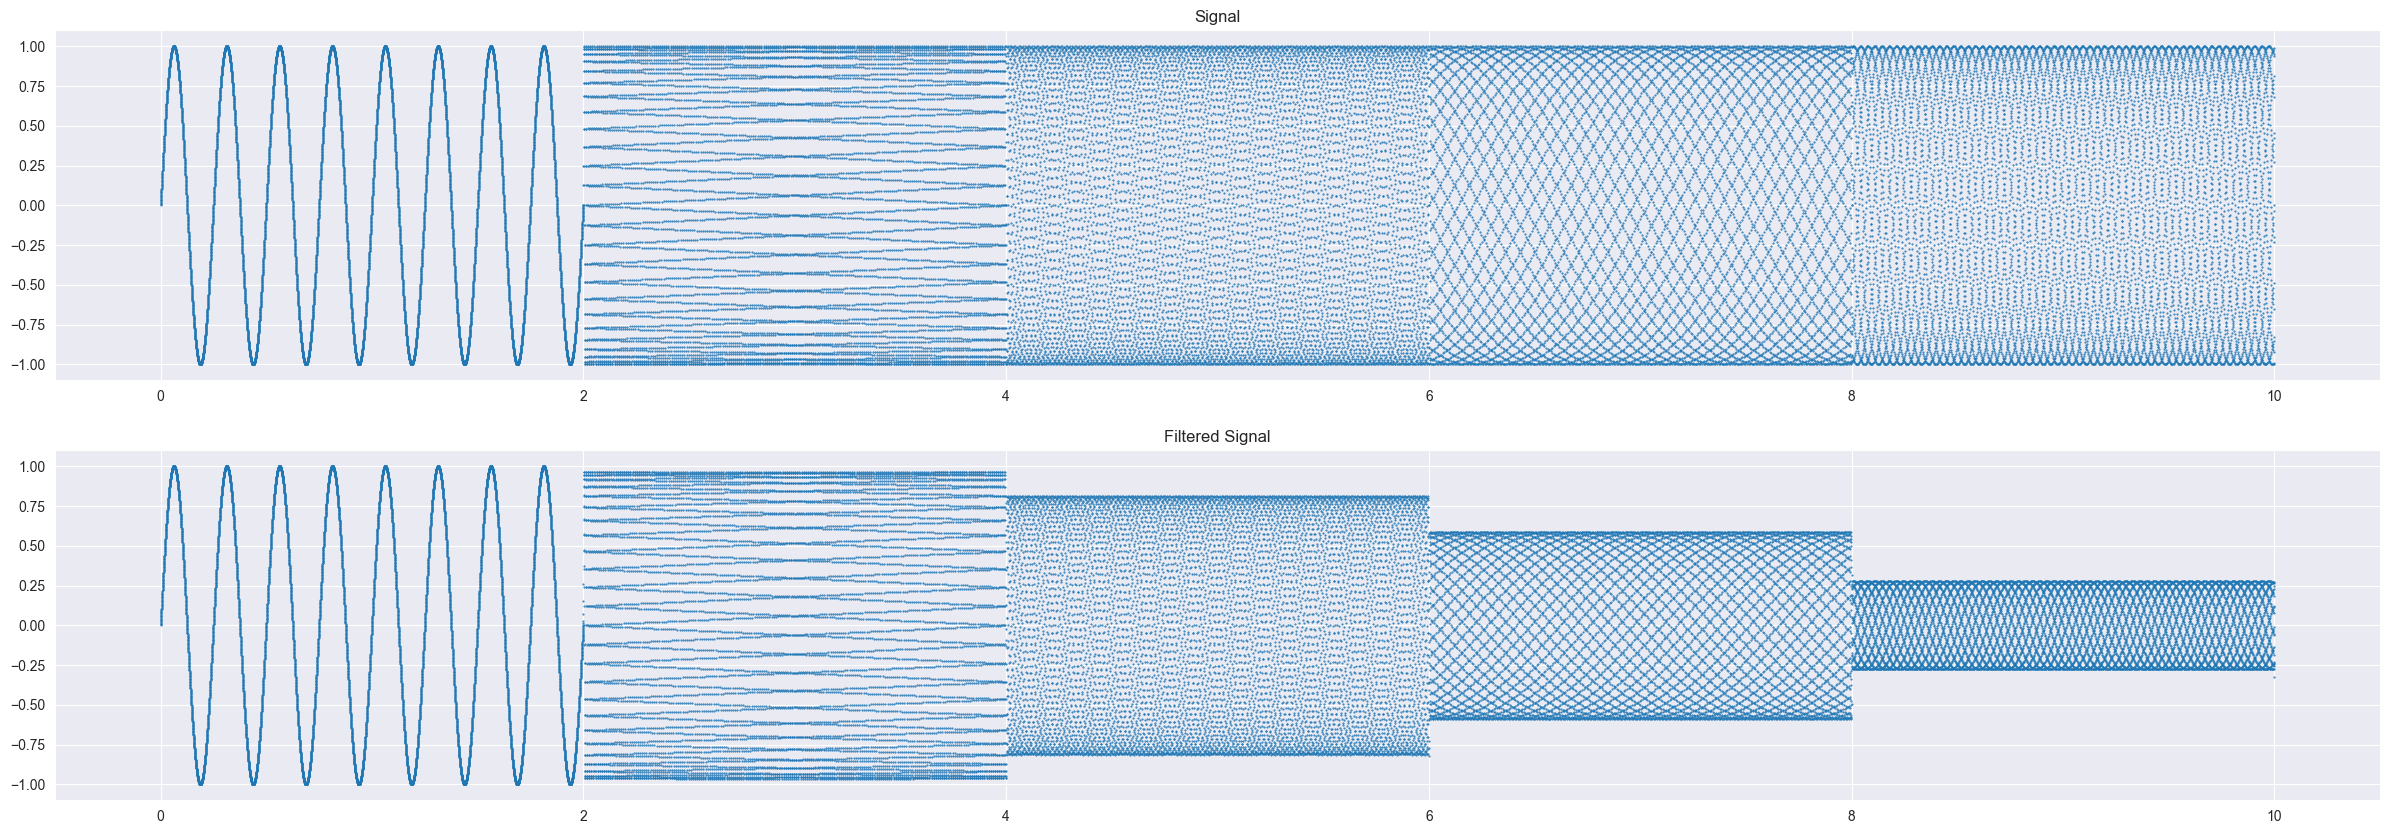

In [352]:
filter_width = 15

sig = np.concatenate([create_sin_signal(8 * i ** 2) for i in range(1, 20, 4)])
xx = np.linspace(0, 10, len(sig))
filtered_sig = filter_signal(sig.copy(), filter_width, a=1)

fig, axs = plt.subplots(2, 1, figsize=(30, 10))
axs[0].plot(xx, sig, ".", markersize=1)
axs[0].set_title("Signal")
axs[1].plot(xx, filtered_sig, ".", markersize=1)
axs[1].set_title("Filtered Signal")
plt.show()

In [8]:
build_point_grid(3)

array([[0.16666667, 0.16666667],
       [0.5       , 0.16666667],
       [0.83333333, 0.16666667],
       [0.16666667, 0.5       ],
       [0.5       , 0.5       ],
       [0.83333333, 0.5       ],
       [0.16666667, 0.83333333],
       [0.5       , 0.83333333],
       [0.83333333, 0.83333333]])